<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project%5CKalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [107]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


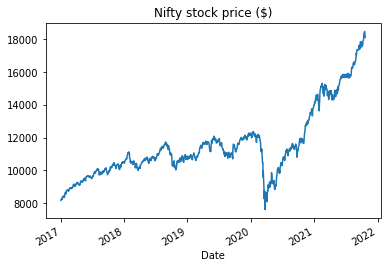

In [137]:
#ticker= yf.Ticker('TSLA')
nifty_df = yf.download('^nsei',start='2017-01-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [138]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [139]:
df = nifty_df[['Adj Close']]


mean 15685.058875671311


Text(0.5, 0, 'Days')

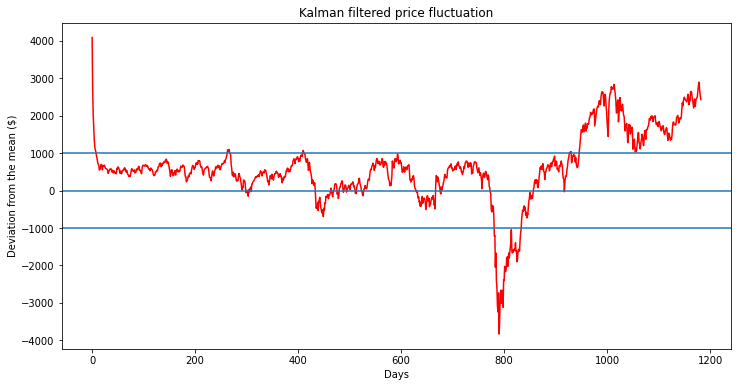

In [140]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')


plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [141]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [142]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(append=True)

print()

In [143]:
nifty=nifty.set_index('date')

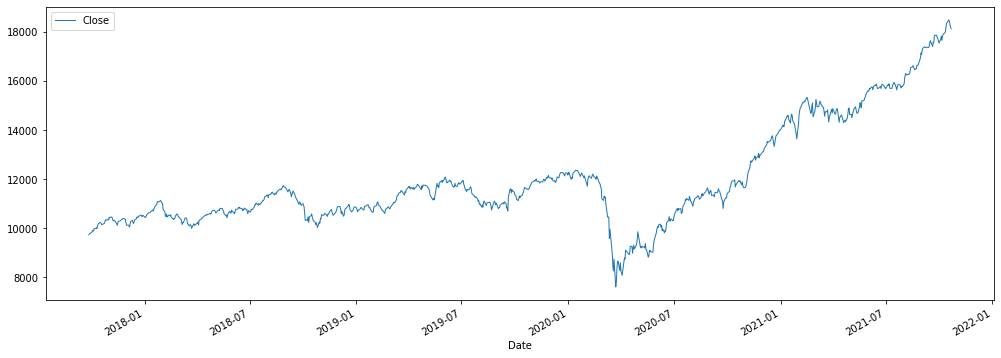

In [144]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

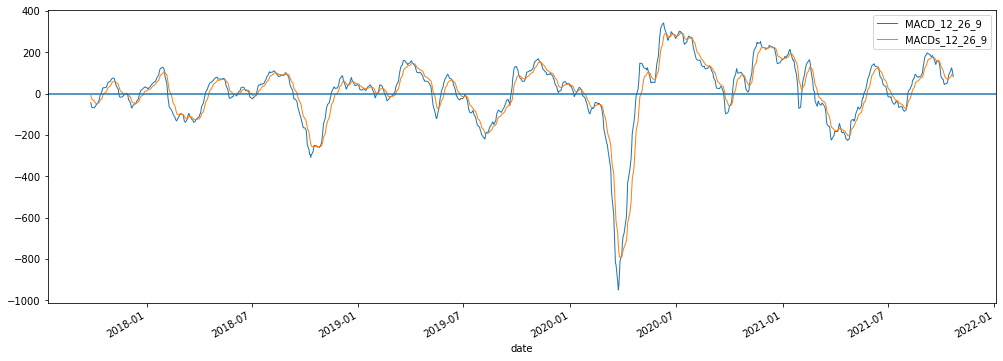

In [145]:
nifty[['MACD_12_26_9','MACDs_12_26_9']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0)

In [146]:
df['signals']=0

for i in range(len(df)):
  if nifty['MACD_12_26_9'].iloc[i]>nifty['MACDs_12_26_9'].iloc[i] and nifty['MACD_12_26_9'].iloc[i-1]<nifty['MACDs_12_26_9'].iloc[i-1]:
    df['signals']=1
  elif nifty['MACD_12_26_9'].iloc[i]<nifty['MACDs_12_26_9'].iloc[i] and nifty['MACD_12_26_9'].iloc[i-1]>nifty['MACDs_12_26_9'].iloc[i-1]:
    df['signals']=-1  
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [147]:
df['signals_zeroline']=np.where(nifty['MACD_12_26_9']>0,1,-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
df['sum']=df['signals']+df['signals_zeroline']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [149]:
df

,Adj Close,signals,signals_zeroline,sum
Date,,,,
2017-01-02,8179.500000,-1,-1,-2
2017-01-03,8192.250000,-1,-1,-2
2017-01-04,8190.500000,-1,-1,-2
2017-01-05,8273.799805,-1,-1,-2
2017-01-06,8243.799805,-1,-1,-2
...,...,...,...,...
2021-10-18,18477.050781,-1,1,0
2021-10-19,18418.750000,-1,1,0
2021-10-20,18266.599609,-1,1,0


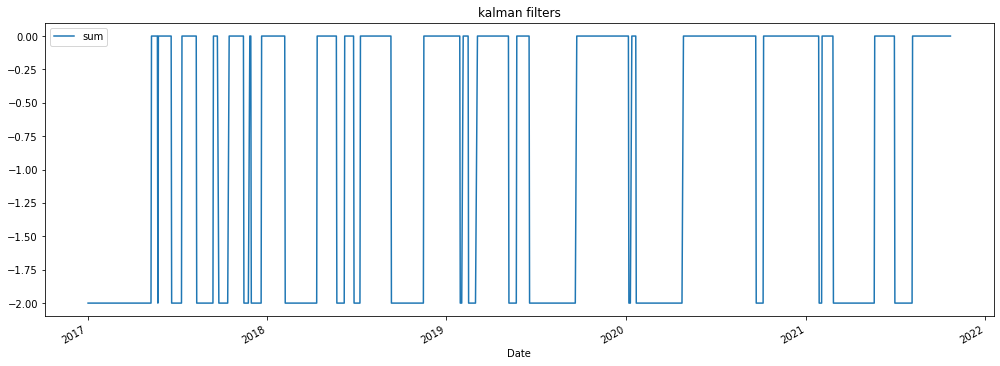

In [150]:
df['sum'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

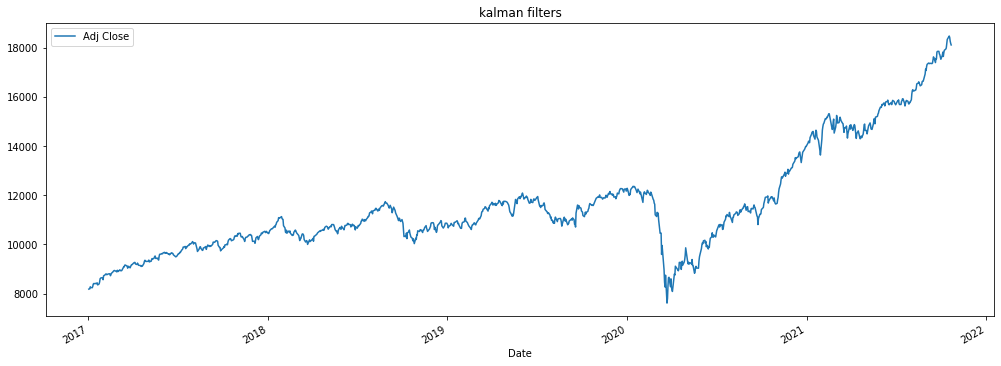

In [151]:
df['Adj Close'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

In [152]:
df

,Adj Close,signals,signals_zeroline,sum
Date,,,,
2017-01-02,8179.500000,-1,-1,-2
2017-01-03,8192.250000,-1,-1,-2
2017-01-04,8190.500000,-1,-1,-2
2017-01-05,8273.799805,-1,-1,-2
2017-01-06,8243.799805,-1,-1,-2
...,...,...,...,...
2021-10-18,18477.050781,-1,1,0
2021-10-19,18418.750000,-1,1,0
2021-10-20,18266.599609,-1,1,0


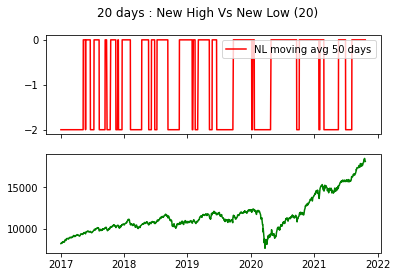

In [153]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(df.loc[:, :].index, df.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()
